In [1]:
import warnings
import logging
# warnings.filterwarnings("ignore")

In [5]:
import datetime
import glob
from functools import lru_cache, partial
from pprint import pprint
import ray

import gym_trading_env
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import torch
from gym_trading_env.downloader import download
from gym_trading_env.environments import TradingEnv
from gym_trading_env.renderer import Renderer
from IPython.display import display
from ray import train, tune
from tqdm.autonotebook import tqdm
from utils.utils import  build_market_image,preprocess_data,stack_arrays

from utils.utils import build_market_image
from environments.environments import NeuralForecastingTradingEnv
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from neuralforecast.core import NeuralForecast
from ray.tune.schedulers import HyperBandScheduler
from ray.tune import ProgressReporter,JupyterNotebookReporter
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.optuna import OptunaSearch 
from ray.tune.search.hyperopt import HyperOptSearch

from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.appo import APPOConfig
from ray.rllib.algorithms.dreamerv3 import DreamerV3Config
from ray.tune.logger import pretty_print
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.evaluation.worker_set import WorkerSet
from ray.rllib.evaluation.metrics import summarize_episodes
from ray.rllib.env import BaseEnv
from ray.rllib.policy import Policy
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from typing import Dict, Tuple
from ray.tune.registry import register_env
from ray.rllib.algorithms import ppo

2024-10-04 07:32:01,631	WARNING deprecation.py:50 -- DeprecationWarning: `WorkerSet` has been deprecated. Use `ray.rllib.env.env_runner_group.EnvRunnerGroup` instead. This will raise an error in the future!


In [6]:
from IPython.display import display, HTML
import tensorboard

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">') # make sure the path is correct, it fails silently otherwise
display(css)

In [7]:
COIN_PAIRS=['BTC/USDT','ETH/USDT','SOL/USDT','BNB/USDT','XRP/USDT','ADA/USDT',
            'ETH/BTC','SOL/ETH','BNB/ETH','XRP/ETH',"ADA/ETH",
            'SOL/BTC','SOL/BNB',
            'XRP/BTC','XRP/BNB',
            'ADA/BTC','ADA/BNB',
            ]
target_pair='BNB/USDT'
time_frame="1h"
symbol=target_pair.replace('/','')
symbol

'BNBUSDT'

In [8]:

# download(exchange_names = ["binance"],
#     symbols= tqdm(COIN_PAIRS),
#     timeframe= time_frame,
#     dir = "data",
#     since= datetime.datetime(year= 2022, month= 1, day=1),
# )

In [11]:
model=NeuralForecast.load("forecasting_model/")

Seed set to 5
Seed set to 11
Seed set to 17
Seed set to 6


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
symbol

'BNBUSDT'

In [15]:
data=build_market_image(target_pair=symbol,time_frame='1h',axis=0,only_target=True)
data=data[data['symbol']==symbol].copy()
data['ds']=data.index

['data/binanceus-BNBUSDT-1h.pkl']


0it [00:00, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

In [16]:
split_date=datetime.datetime(year= 2024, month= 4, day=1)
end_date=split_date+datetime.timedelta(days=14)


hf_data=data.copy()

hf_train_data=hf_data.groupby('symbol').apply(lambda x: x[:split_date])
hf_test_data=hf_data.groupby('symbol').apply(lambda x: x[split_date:])

hf_train_data=hf_train_data.reset_index(level=0,drop=True).reset_index()
hf_test_data=hf_test_data.reset_index(level=0,drop=True).reset_index()


trade_data=data[data['symbol']==symbol].copy()
train_data=trade_data[:split_date]
test_data=trade_data[split_date:end_date]
# hf_test_data

In [17]:
train_data.head(5)

,open,high,low,close,volume,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,feature_MFV,feature_14_period_ADX,feature_AO,feature_APZ_UPPER,feature_APZ_LOWER,feature_14_period_ATR,feature_BASP_Buy,feature_BASP_Sell,feature_BASPN_Buy,feature_BASPN_Sell,feature_BBANDS_BB_UPPER,feature_BBANDS_BB_MIDDLE,feature_BBANDS_BB_LOWER,feature_20_period_BBWITH,feature_Balance_Of_Power,feature_20_period_CCI,feature_CFI,feature_CHANDELIER_Short,feature_CHANDELIER_Long,feature_CMO,feature_Coppock_Curve,feature_9_period_DEMA,feature_DMI_DI+,feature_DMI_DI-,feature_DO_LOWER,feature_DO_MIDDLE,feature_DO_UPPER,feature_EBBP_Bull,feature_EBBP_Bear,feature_13_period_Force_Index,...,feature_14_period_PZO,feature_ROC,feature_14_period_RSI,feature_41_period_SMA,feature_9_period_SMM,feature_SMMA,feature_20_period_SQZMI,feature_9_period_SSMA,feature_10_period_STC,feature_14_period_STOCH_%K,feature_3_period_STOCH_%D,feature_14_period_stochastic_RSI,feature_9_period_TEMA,feature_TP,feature_TR,feature_18_period_TRIMA,feature_20_period_TRIX,feature_TSI_TSI,feature_TSI_signal,feature_8_period_VAMA,feature_VBM,feature_VFI,feature_VORTEX_VIm,feature_VORTEX_VIp,feature_VPT,feature_VWAP,feature_VW_MACD_MACD,feature_VW_MACD_SIGNAL,feature_VZO,feature_14_Williams_%R,feature_WILLIAMS_FRACTAL_BearishFractal,feature_WILLIAMS_FRACTAL_BullishFractal,feature_9_period_WMA,feature_WOBV,feature_WTO_WT1,feature_WTO_WT2,feature_26_period_ZLEMA,ds,unique_id,symbol
date_close,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,515.7360,516.9400,513.7700,515.3371,170.18,515.3371,-0.065217,0.333333,-0.5,-0.5,0.0,0.0,0.0,521.677100,508.997100,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,-0.125836,0.000000,0.0,0.0,0.0,0.000000,0.0,515.337100,0.0,0.0,0.0000,0.0,0.0,1.602900,-1.567100,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,515.337100,False,515.337100,0.0,0.0,0.0,0.0,515.337100,515.349033,3.1700,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-42.829528,515.349033,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,2022-01-01 10:00:00,5,BNBUSDT
2022-01-01 11:00:00,516.0451,516.1901,512.6315,515.0445,77.30,515.0445,-0.021739,0.333333,-0.5,-0.5,0.0,0.0,0.0,521.664095,508.557604,0.0,0.760598,0.527887,0.874314,0.752141,0.0,0.0,0.0,0.0,-0.281178,-66.666667,0.0,0.0,0.0,-100.000000,0.0,515.102298,0.0,0.0,0.0000,0.0,0.0,1.010554,-2.548046,-22.617980,...,-53.557302,0.0,0.000000,0.0,0.0,515.189037,False,515.182194,0.0,0.0,0.0,0.0,515.070188,514.622033,3.5586,0.0,-0.008217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-86.299646,515.121956,-0.005907,-0.003282,-34.387753,0.0,0.0,0.0,0.0,-22.617980,-121.212121,0.00000,0.0,2022-01-01 11:00:00,5,BNBUSDT
2022-01-01 12:00:00,515.1545,515.6547,513.9585,514.1481,28.27,514.1481,0.021739,0.333333,-0.5,-0.5,0.0,0.0,0.0,520.694507,508.342883,0.0,0.043797,0.335650,0.569353,0.599208,0.0,0.0,0.0,0.0,-0.593326,-53.519298,0.0,0.0,0.0,-100.000000,0.0,514.462966,0.0,0.0,0.0000,0.0,0.0,0.873113,-0.823087,-24.084344,...,-71.276585,0.0,0.000000,0.0,0.0,514.833664,False,514.796196,0.0,0.0,0.0,0.0,514.314973,514.587100,1.6962,0.0,-0.014589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-119.846312,515.067122,-0.022760,-0.011265,-42.702243,0.0,0.0,0.0,0.0,-47.959208,-96.566945,0.00000,0.0,2022-01-01 12:00:00,5,BNBUSDT
2022-01-01 13:00:00,514.9197,517.1231,514.6964,516.9275,32.00,516.9275,0.065217,0.333333,-0.5,-0.5,0.0,0.0,0.0,521.576676,509.710558,0.0,0.602740,0.077647,0.578991,0.448641,0.0,0.0,0.0,0.0,0.827379,116.897131,0.0,0.0,0.0,45.397820,0.0,515.784727,0.0,0.0,0.0000,0.0,0.0,1.675406,-0.751294,19.523782,...,-18.727149,0.0,71.929445,0.0,0.0,515.376193,False,515.426509,0.0,0.0,0.0,0.0,516.073985,516.249000,2.9750,0.0,-0.001977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-66.894073,515.190015,0.027731,0.001945,-22.437654,0.0,0.0,0.0,0.0,40.981592,-8.757052,0.00000,0.0,2022-01-01 13:00:00,5,BNBUSDT
2022-01-01 14:00:00,517.4822,517.8325,516.4450,516.9602,9.41,516.9602,0.108696,0.333333,-0.5,-0.5,0.0,0.0,0.0,52

In [18]:
def prep_forecasts(df):
    forecast_array=[]
    # print(self.df.columns)

    model.dataset, model.uids, model.last_dates, model.ds=model._prepare_fit(df[['ds','unique_id','y']],
                                                                                        static_df=None, 
                                                                                        sort_df=None,
                                                                                        predict_only=False,
                                                                                        id_col='unique_id', 
                                                                                        time_col='ds', 
                                                                                        target_col='y')
    forecasts=model.predict_insample()
    forecasts_series=forecasts.groupby('cutoff').apply(lambda x: x.select_dtypes(np.number).values.flatten())
    new_df=df[df['ds'].isin([c for c in forecasts_series.index])]
    forecasts_series=forecasts_series[new_df.index]
    forecast_array=[c for c in forecasts_series]
    return forecast_array,new_df

In [19]:
train_forecast_array,train_df=prep_forecasts(train_data)
test_forecast_array,test_df=prep_forecasts(test_data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
def rew_func(history):
    portfolio_initial_value= history["portfolio_valuation",0]
    current_position=history['position',-1]
    portfolio_return=history["portfolio_valuation"]
    portfolio_pct_change=pd.Series(np.array(portfolio_return)).pct_change().fillna(0)
    # print(portfolio_pct_change)
    reward = (portfolio_pct_change.mean() / portfolio_pct_change.std())
    
    # print(np.isnan(reward),reward)
    reward = 0 if np.isnan(reward) else reward
    # print(np.isnan(reward),reward)
    return float(reward)


In [27]:
train_env_config=dict(
                name=f'{symbol}_train',
                forecast_horizon=7,
                context_length=35,
                # initial_position=0,
                reward_function=rew_func,
                forecasts=train_forecast_array,
                df = train_df, # Your dataset with your custom features
                positions = [ -1, -.5, 0, .5 , 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
                trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
                borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
                max_episode_duration=168,
                verbose=0
                )

test_env_config=copy.deepcopy(train_env_config)
test_env_config['name']=f'{symbol}_test'
test_env_config['df'] = test_df
test_env_config['forecasts']=test_forecast_array



In [28]:
train_env=NeuralForecastingTradingEnv(**train_env_config)

In [29]:
obs=train_env.reset()
terminated = truncated = False
# env.action_space.sa
while not terminated and not truncated:
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
info['reward']
# train_env.results_metrics
# train_env.historical_info.columns

-0.023083280056553683

In [30]:


register_env("train_env", lambda config: NeuralForecastingTradingEnv(**train_env_config))
register_env("test_env", lambda config: NeuralForecastingTradingEnv(**test_env_config))


In [31]:

def trial_str_creator(trial):
    return "{}_{}_trading_agent".format(trial.trainable_name, trial.trial_id)



In [32]:
from ray.rllib.algorithms.algorithm import Algorithm

In [33]:
agent= Algorithm.from_checkpoint('Agent/final_checkpoints')

2024-10-04 07:37:39,269	WARNING util.py:61 -- Install gputil for GPU system monitoring.


In [34]:
test_env=NeuralForecastingTradingEnv(**test_env_config)

In [35]:
# obs,info=train_env.reset()
# action=None
# reward=0
# terminated = truncated = False

# while not terminated and not truncated:

#     action = agent.compute_single_action(obs,explore=False)
#     action = train_env.action_space.sample()
#     # print(action)
#     next_obs, reward, terminated, truncated, info = train_env.step(action)

#     obs=next_obs
# info
# train_env.get_metrics(),info['portfolio_valuation']

In [36]:
# eval_profit=[]
# for i in tqdm( range(100)):
#     obs,info=train_env.reset()
#     action=None
#     reward=0
#     terminated = truncated = False

#     while not terminated and not truncated:

#         action = agent.compute_single_action(obs,explore=False)
#         # action = train_env.action_space.sample()
#         # print(action)
#         next_obs, reward, terminated, truncated, info = train_env.step(action)

#         obs=next_obs

#     eval_profit.append(info['portfolio_valuation'])
#     info['portfolio_valuation']
# profits=[e for e in eval_profit]
# plt.plot(profits)
# np.mean(profits)

In [37]:
eval_profit=[]
eval_market=[]
for i in tqdm( range(100)):
    obs,info=test_env.reset()
    action=None
    reward=0
    terminated = truncated = False

    while not terminated and not truncated:

        action = agent.compute_single_action(obs,explore=False)
        # action = train_env.action_space.sample()
        # print(action)
        next_obs, reward, terminated, truncated, info = test_env.step(action)

        obs=next_obs
    metrics=test_env.get_metrics()
    eval_market.append(float(metrics['Market Return'].replace('%','')))
    eval_profit.append(float(metrics['Portfolio Return'].replace('%','')))

    # info['portfolio_valuation']


  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
pd.to_numeric(eval_profit)

array([-4.12, -3.92,  2.25, -4.99, -2.44, -3.5 ,  4.02, -3.42, -3.76,
       -3.33, -3.25, -4.04, -3.29, -2.7 , -4.36, -5.4 , -3.26, -3.81,
       -2.45, -6.95, -4.36, -7.13, -3.05,  1.26, -7.59, -2.95, -3.86,
       -3.18, -5.26, -4.16, -3.5 ,  4.02, -6.95, -2.43, -2.23, -3.09,
       -4.36, -7.57, -0.47, -6.95, -4.5 , -2.56,  4.03,  2.9 , -0.11,
       -2.79,  3.53, -2.79, -3.27, -3.79, -4.37,  2.24,  0.52, -2.58,
       -5.  , -3.92, -4.88, -3.08,  4.65,  2.5 , -4.86, -4.65, -3.47,
        4.46, -2.55, -3.38, -3.33, -7.23,  1.42, -4.8 , -3.13, -3.18,
       -4.39, -4.81, -4.55, -2.85, -3.43, -3.8 , -3.55,  4.65, -3.05,
       -4.66, -4.66, -4.24, -3.48, -3.02, -3.21, -3.74, -4.51, -3.53,
       -5.53, -3.42, -5.53, -3.88,  1.07, -0.47, -2.96, -2.59, -4.81,
       -4.26])

(18.341600000000007, 2.3903)

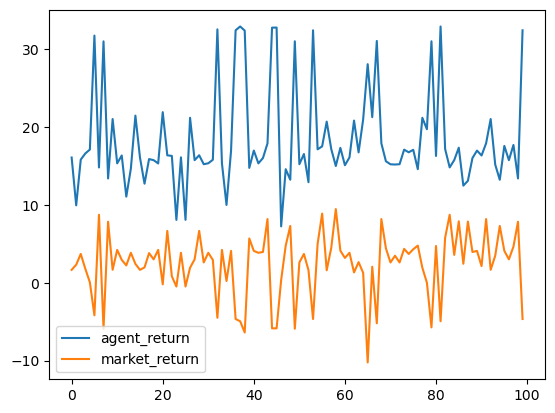

In [53]:

plt.plot(eval_profit,label='agent_return')
plt.plot(eval_market,label='market_return')
plt.legend()
np.mean(eval_profit),np.mean(eval_market)

In [39]:
render_dir="PPO_test_render_logs"
renderer = Renderer(render_logs_dir=render_dir)

In [40]:
obs,info=test_env.reset()
action=None
reward=0
terminated = truncated = False


while not terminated and not truncated:

    action = agent.compute_single_action(obs,explore=False)
    # action = train_env.action_space.sample()
    # print(action)
    next_obs, reward, terminated, truncated, info = test_env.step(action)

    obs=next_obs
info['reward'],info[ 'portfolio_valuation'],test_env.get_metrics()




(-0.06972639759268905,
 956.2868850972924,
 {'Market Return': ' 4.09%',
  'Portfolio Return': '-4.37%',
  'Position Changes': 29,
  'Episode Length': 168})

In [41]:

test_env.save_for_render(dir = render_dir)

In [42]:
renderer = Renderer(render_logs_dir=render_dir)

In [58]:
# Add Custom Metrics (Annualized metrics)
renderer.add_metric(
    name = "Annual Market Return",
    function = lambda df : f"{ ((df['close'].iloc[-1] / df['close'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)
renderer.add_metric(
        name = "Annual Portfolio Return",
        function = lambda df : f"{((df['portfolio_valuation'].iloc[-1] / df['portfolio_valuation'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)

renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [04/Oct/2024 07:38:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Oct/2024 07:38:18] "GET /update_data/ETHUSDT_test_2024-08-22_15-08-17.pkl HTTP/1.1" 200 -
127.0.0.1 - - [04/Oct/2024 07:38:18] "GET /metrics HTTP/1.1" 200 -
127.0.0.1 - - [04/Oct/2024 07:38:18] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Oct/2024 07:38:41] "GET /update_data/BNBUSDT_test_2024-10-04_07-38-09.pkl HTTP/1.1" 200 -
127.0.0.1 - - [04/Oct/2024 07:38:41] "GET /metrics HTTP/1.1" 200 -
